## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
os.environ['XLA_FLAGS'] = "--xla_disable_hlo_passes=constant_folding"
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jaxquantum.codes as jqtb
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import numpy as np
from jax_tqdm import scan_tqdm
from jaxopt import GaussNewton
from sbs import sbs
plt.style.use('ggplot')

/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check CUDA devs

In [3]:
jax.devices()

[CudaDevice(id=0)]

In [4]:
jax.devices()[0]

CudaDevice(id=0)

In [5]:
jax.devices()[0].memory_stats()

## Declare circuit parameters

In [6]:
N = 70
T = 40
default_chi = 34e-6*2*jnp.pi
t_sqg = 56 #ns
t_reset = 348 #ns

In [7]:
linear_betas = np.load("cd_delay_times.npz", allow_pickle = True)["data"].tolist()[10.5]["betas"][7:]

In [8]:
linear_delays = np.load("cd_delay_times.npz", allow_pickle = True)["data"].tolist()[10.5]["total_ecd_times"][7:]

In [9]:
p = jnp.polyfit(linear_betas, linear_delays, 1)

## Sweep circuit parameters

In [177]:
delta = 0.438
sd_ratio = 1.857
gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": N})
vac = jqt.basis(2, 0) ^ jqt.basis(N, 0)
plus_Z = jqt.basis(2, 0) ^ gkp_qubit.basis["-x"]
initial_state = plus_Z

logical_Z = gkp_qubit.common_gates["X_0"]
freq_res = 4.138e9
freq_qb = 233e6
k_B = 1.380649e-23
h = 6.62607015e-34
T_res = 40e-3
T_qb = 40e-3
n_bar_qb = 1/(jnp.exp(h*freq_qb/k_B/T_qb)-1)
n_bar_res = 1/(jnp.exp(h*freq_res/k_B/T_res)-1)
error_channels = {
    "resonator": {
        "selfkerr": 0,
        "chi": 31.7e-6*2*jnp.pi,
        "T1": 89e3,
        "Tphi": 80e3*1e6,
        "n_bar": n_bar_res,
    },
    "fluxonium": {
        "T1": 93e3,
        "Tphi": 30.4e3,
        "n_bar": n_bar_qb,
        "reset_p_eg": 0.0783*0,
        "reset_p_ee": 0.0783,
        "t_rst": t_reset
    }
}

In [178]:
t_CD_floor = linear_delays[0]
t_CD_p = p

ts, res = sbs(initial_state = initial_state,
            delta=delta,
            sd_ratio=sd_ratio,
            T=T,
            observable=logical_Z,
            t_sqg = t_sqg,
            t_CD_floor = t_CD_floor,
            t_CD_p = t_CD_p,
            t_rst=t_reset,
            error_channels=error_channels,
            )

Running for 40 iterations: 100%|████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 88.02it/s]


In [179]:
def fit_t1(times, amps, guess):
    def exponential(x, x_data, y_data):
        return y_data-x[0]*jnp.exp(x[1]*x_data)
    gn = GaussNewton(residual_fun=exponential, tol=1e-9, maxiter=1000)
    gn_sol = gn.run(guess, x_data=times, y_data=amps)
    return gn_sol.params, gn_sol.state.error

In [180]:
fit_res = fit_t1(ts, jnp.abs(res), jnp.array([0.8, -1/500e3]))
coeff = fit_res[0]
residuals = fit_res[1]
t1 = -1/coeff[1]

In [181]:
# ts_exp = jnp.array([ 0.348,  6.004, 11.66 , 17.316, 22.972, 28.628, 34.284, 39.94,
#          45.596, 51.252, 56.908, 62.564, 68.22 , 73.876, 79.532, 85.188])
# val_exp = jnp.array([-3.8400e-01,  2.9080e-01, -2.2180e-01,  1.5670e-01, -1.1705e-01,
#           6.7350e-02, -5.7000e-02,  3.0250e-02, -2.1350e-02,  1.5900e-02,
#          -1.8900e-02,  1.2000e-02, -1.1400e-02,  3.0000e-04, -1.2500e-03,
#           3.4000e-03])

In [182]:
# fit_res_exp = fit_t1(ts_exp, jnp.abs(val_exp), jnp.array([0.8, -1/150e3]))
# coeff_exp = fit_res_exp[0]
# residuals_exp = fit_res_exp[1]
# t1_exp = -1/coeff_exp[1]

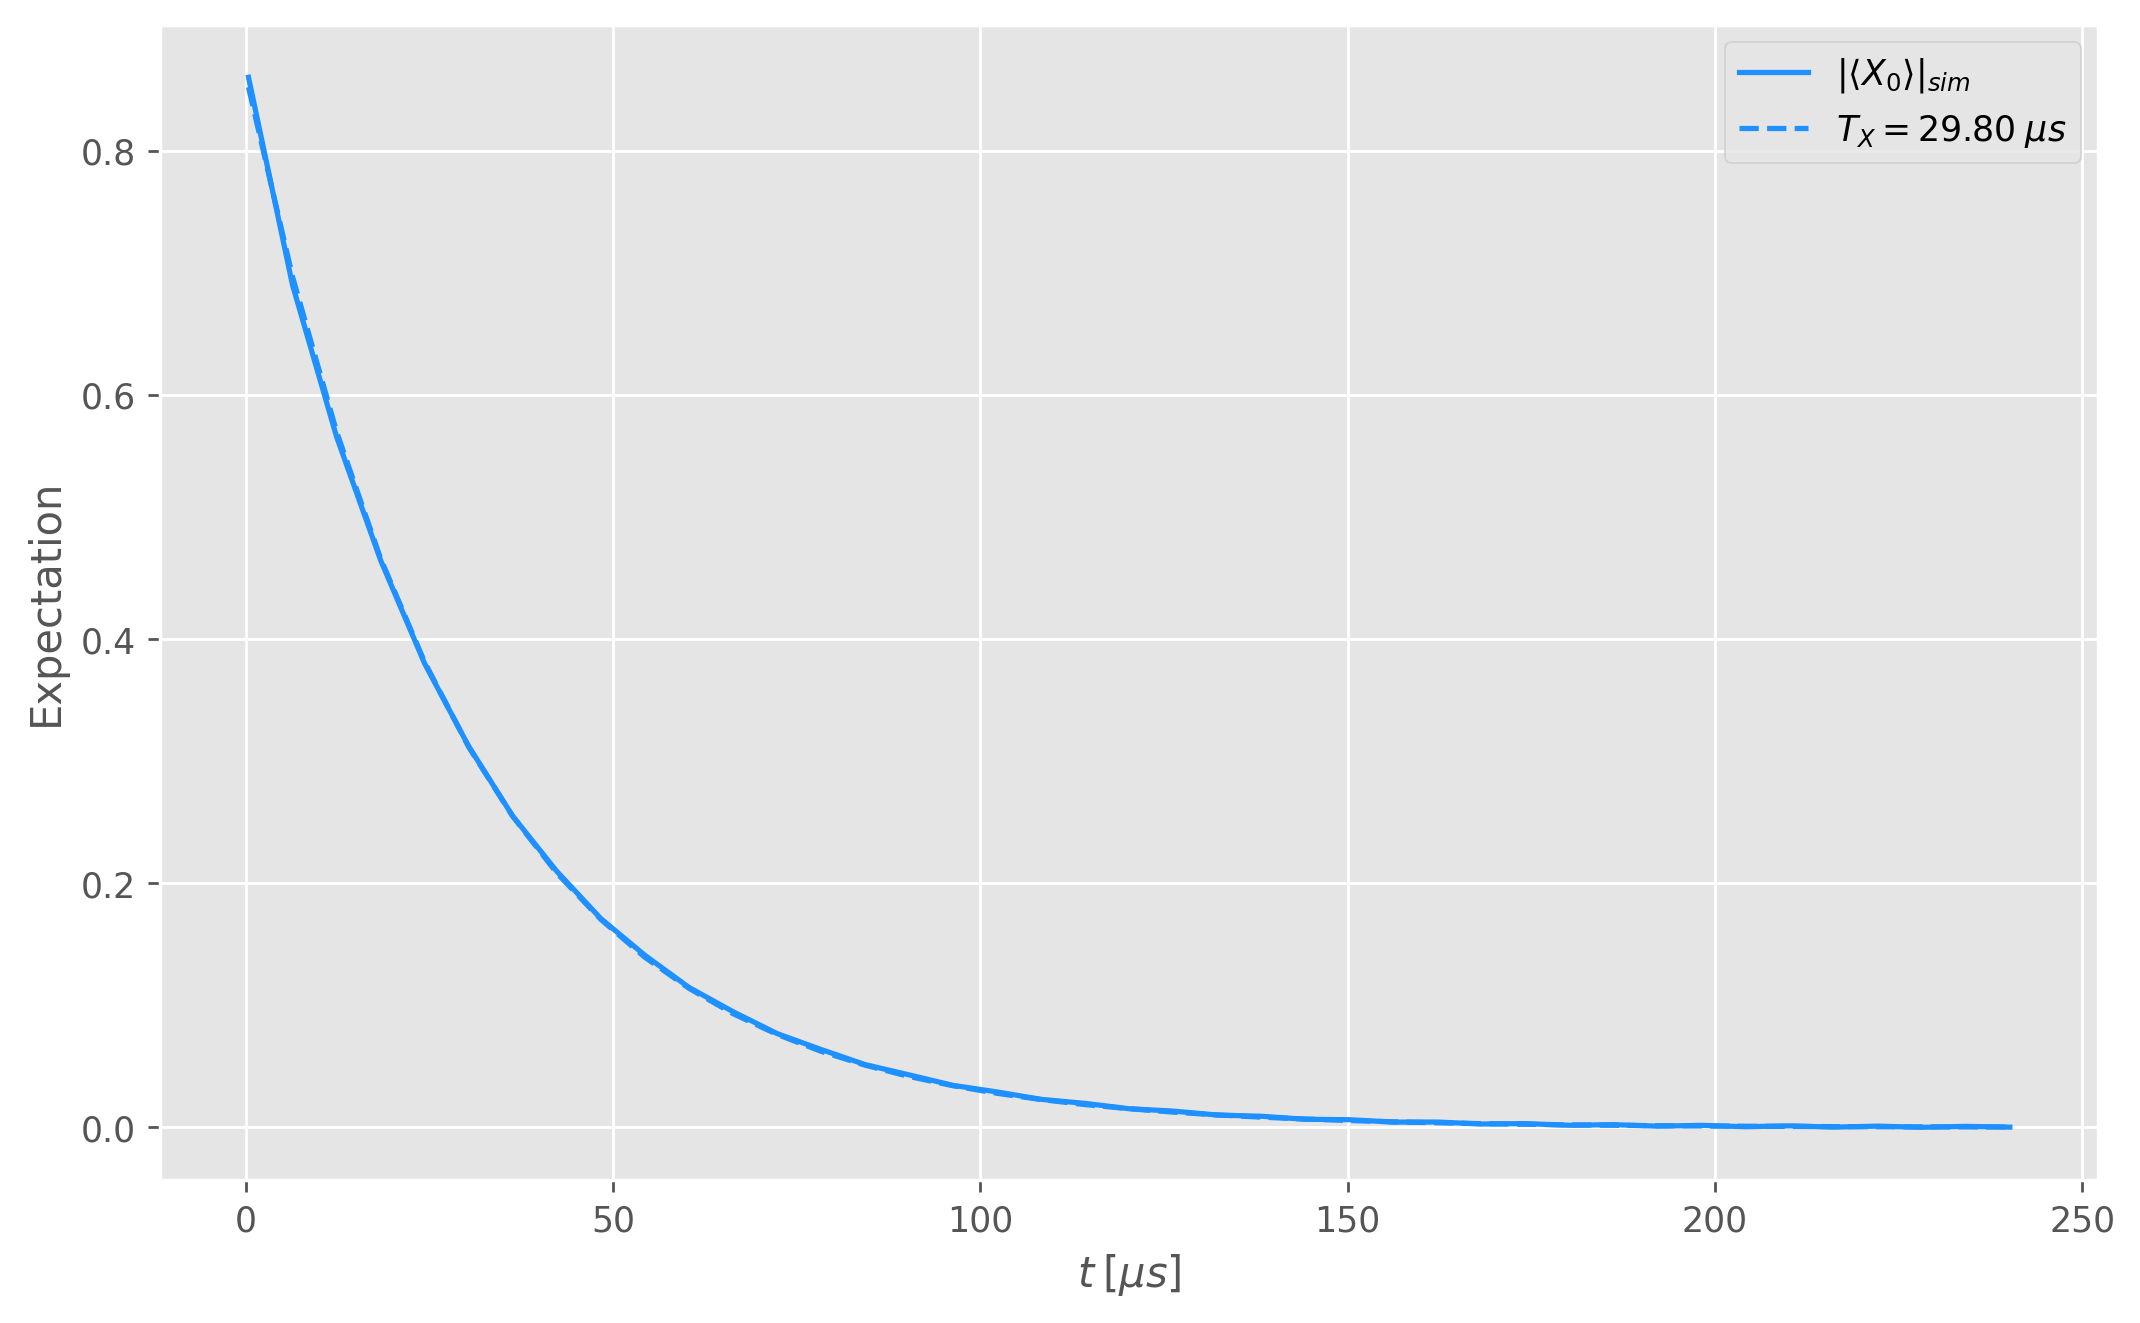

In [183]:
fig, ax = plt.subplots(1, figsize=(10, 6), dpi=250)
# ax.scatter(ts/1e3, res, color="skyblue", label="$\\langle X_0 \\rangle_{sim}$")
ax.plot(ts/1e3, jnp.abs(res), color="dodgerblue", label="$\\vert\\langle X_0 \\rangle\\vert_{sim}$", )#s=25)

# ax.plot(ts/1e3, res, color="skyblue")

fit = coeff[0]*jnp.exp(coeff[1]*ts)
ax.plot(ts/1e3, fit, color="dodgerblue", label=f"$T_X={t1/1e3:.2f} \;\mu s$", ls="--")


# ax.scatter(ts_exp, val_exp, color="lightsalmon", label="$\\langle X_0 \\rangle_{exp}$")
# ax.scatter(ts_exp, jnp.abs(val_exp), color="orangered", label="$\\vert\\langle X_0 \\rangle\\vert_{exp}$", s=25)
# ax.plot(ts_exp, val_exp, color="lightsalmon")
# fit_exp = coeff_exp[0]*jnp.exp(coeff_exp[1]*ts_exp)
# ax.plot(ts_exp, fit_exp, color="orangered", label=f"$T_X={t1_exp:.2f} \;\mu s$", ls="--")

ax.set_xlabel("$t\: [\mu s]$")
ax.set_ylabel("Expectation")
ax.legend()

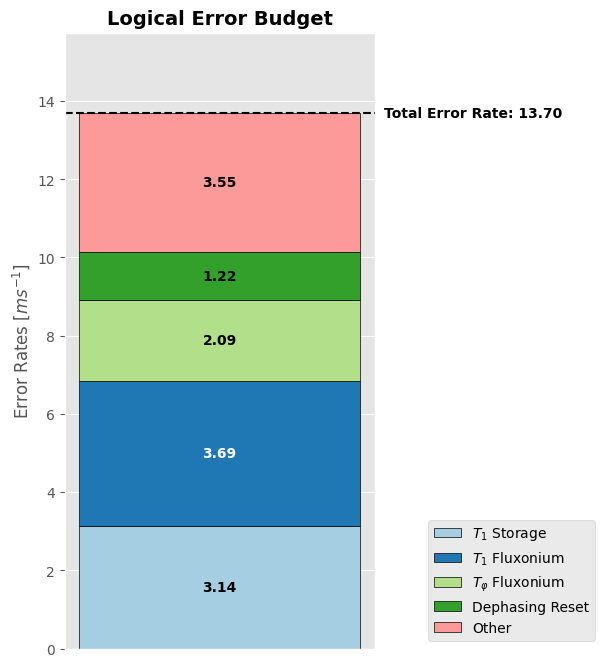

In [103]:
import matplotlib.ticker as mtick
error_budget = {
    '$T_1$ Storage': 1/318*1e3,
    '$T_1$ Fluxonium': 1/271*1e3,
    '$T_{\\varphi}$ Fluxonium': 1/479*1e3,
    'Dephasing Reset': 1/818*1e3,
    'Other': (1/73-(1/318+1/271+1/479+1/818))*1e3
}

# 2. Set up the plot
# We make it taller than it is wide
fig, ax = plt.subplots(figsize=(4, 8))

# Bar plot parameters
bar_width = 0.6
bar_position = 0 # X-coordinate for the single bar
cumulative_height = 0

# Get a color cycle
colors = plt.get_cmap('Paired').colors

# 3. Loop through the data and create the stacked bar
for i, (source, error) in enumerate(error_budget.items()):
    color = colors[i % len(colors)]
    
    # Create the bar segment
    bar = ax.bar(
        bar_position,
        error,
        bar_width,
        bottom=cumulative_height,
        label=source,
        color=color,
        edgecolor='black'
    )

    # --- Optional: Add a text label inside the segment ---
    # Calculate text color for good contrast
    text_color = 'white' if (color[0] * 0.299 + color[1] * 0.587 + color[2] * 0.114) < 0.4 else 'black'
    # Calculate label position (in the middle of the segment)
    label_y = cumulative_height + error / 2
    ax.text(
        bar_position, 
        label_y, 
        f'{error:.2f}', 
        ha='center', 
        va='center', 
        color=text_color, 
        fontweight='bold'
    )
    # --- End of optional text label ---

    # Update the cumulative height for the next segment
    cumulative_height += error

# 4. Customize and prettify the plot

# Add a horizontal line and text for the total error
ax.axhline(cumulative_height, color='black', linestyle='--', linewidth=1.5)
ax.text(
    bar_position + bar_width / 2 + 0.05, 
    cumulative_height, 
    f'Total Error Rate: {cumulative_height:.2f}', 
    va='center', 
    ha='left',
    fontweight='bold'
)

# Set labels and title
ax.set_ylabel('Error Rates [$m s^{-1}$]', fontsize=12)
ax.set_title('Logical Error Budget', fontsize=14, fontweight='bold')

# Format Y-axis as percentages
#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

# Set Y-axis limits to give a little space at the top
ax.set_ylim(0, cumulative_height * 1.15)

# Remove the x-axis ticks and labels as they are meaningless
ax.set_xticks([])

# Add the legend
# We place it outside the plot area to avoid covering the bar
ax.legend(bbox_to_anchor=(1.15, 0.22), loc='upper left', fontsize=10)

# 5. Show the plot
# Use tight_layout to ensure all elements (like the legend) fit
#plt.tight_layout()
plt.show()